In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading test output from the model and converting to time index

filename = r'Brunei_Champion7_GT4_tst_pred_01Mar2019_01Jul2019.csv'
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(filename, parse_dates = ['timestamp'])
df.set_index('timestamp', inplace = True)
df['date'] = df.index


In [13]:
# Changing -1 to 1 and 1 to 0 [1 denotes anomaly, 0 denotes normal]
# Under online system_status

df['anomaly'] = df['prediction']
df.anomaly = df.anomaly.replace(1, 0)
df.anomaly = df.anomaly.replace(-1, 1)
df['sys_status'] = 0
df.loc[df['system_status'] == 'online','sys_status'] = 1
df.loc[df['system_status'] == 'offline','sys_status'] = 0
df['gen_alert'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 1), 'gen_alert'] = 1


In [14]:
# Creating results Dataframe

resultsdf = df[['anomaly','sys_status','alert','gen_alert']].resample('W').sum()
resultsdf.columns = ['anomaly_count','online_status_count','flips_count','gen_alert_count']

x = df[['anomaly','sys_status']].resample('W').count()

resultsdf['TotalCounts'] = x['anomaly']
resultsdf['anomaly_ratio'] = resultsdf['anomaly_count'] / resultsdf['online_status_count']
resultsdf['flips_ratio'] = resultsdf['flips_count'] / resultsdf['online_status_count']
resultsdf['gen_alert_ratio'] = resultsdf['gen_alert_count'] / resultsdf['online_status_count']

#resultsdf = resultsdf[resultsdf['TotalCounts'] > 200]


In [7]:
# df['year_week'] = df['date'].dt.strftime('%Y-%U')
# df['year_month'] = df['date'].dt.strftime('%Y-%m')
# resultsdf = pd.DataFrame()
# for cnt in df['year_week'].unique():
#     print(cnt)
#     newdf = df[df['year_week']==cnt]
#     resultsdresultsdf.loc[k,'anomaly'] = newdf[newdf['Prediction']==-1]
#     resultsdf.loc[k,'noanomaly'] = newdf[newdf['Prediction']==1]
#     resultsdresultsdf.loc[k,'alert'] = newdf[newdf['alerts']==-1]
#     resultsdf.loc[k,'noalert'] = newdf[newdf['Prediction']==1]

In [15]:
len(resultsdf) #datapoints  

19

<IPython.core.display.Javascript object>


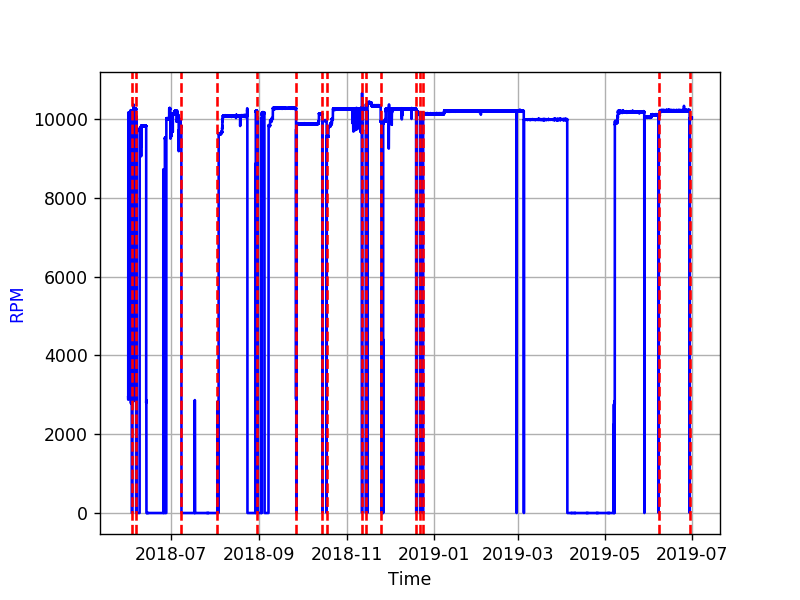

In [16]:
# Plotting entire dataset 

%matplotlib notebook

#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#pdf = pd.read_csv(r'gt4_master_data.csv',parse_dates=['timestamp'], date_parser = dateparse)
pdf = pd.read_csv(r'gt4_master_data.csv', parse_dates = ['timestamp'])
pdf.set_index('timestamp', inplace = True)

# Loading the Failure file 

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT4-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
pdf = pdf[pdf.index <= resultsdf.index[-1]]

fig, ax1 = plt.subplots()
# Steady state plotting.

ax1.plot(pdf['CPCX07-DCS-GT4_XZA4754_NEW'], 'b-', label = 'RPM')
ax1.set_xlabel('Time')
ax1.set_ylabel('RPM', color = 'b')
ax1.grid(True)
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')
plt.show()


In [17]:
# Reloading the failure dataframe

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT4-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
dffailure = dffailure[dffailure['Trip Start Date'] >= resultsdf.index[0]]
dffailure = dffailure[dffailure['Trip Start Date'] <= resultsdf.index[-1]]


<IPython.core.display.Javascript object>


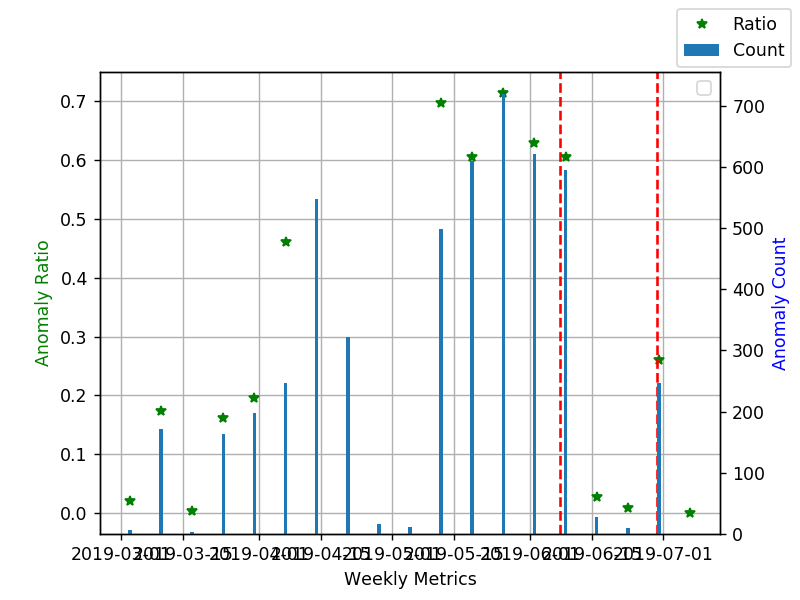

In [18]:
# Create anomaly ratio plot

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(resultsdf['anomaly_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['anomaly_count'], label = 'Count')
ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Anomaly Ratio', color = 'g')
ax2.set_ylabel('Anomaly Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()


<IPython.core.display.Javascript object>


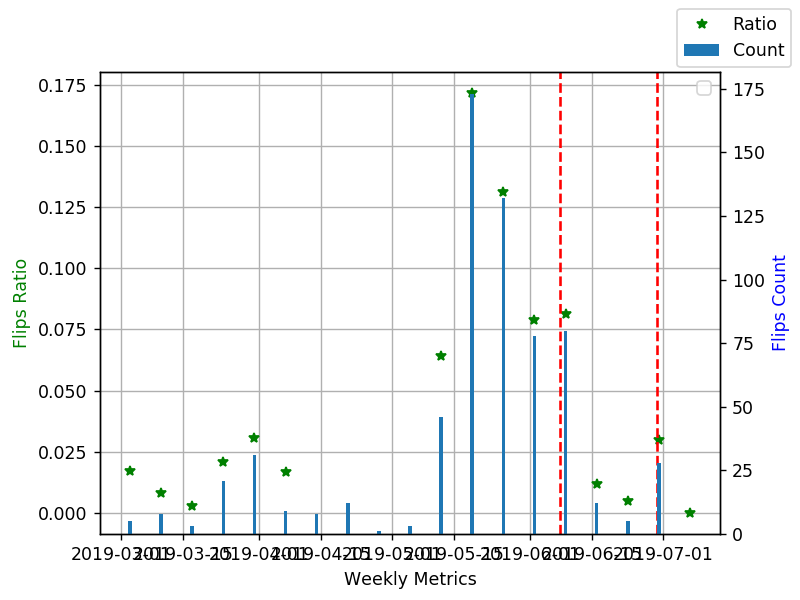

In [20]:
# Create flips ratio plot

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(resultsdf['flips_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index,resultsdf['flips_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Flips Ratio', color = 'g')
ax2.set_ylabel('Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

<IPython.core.display.Javascript object>


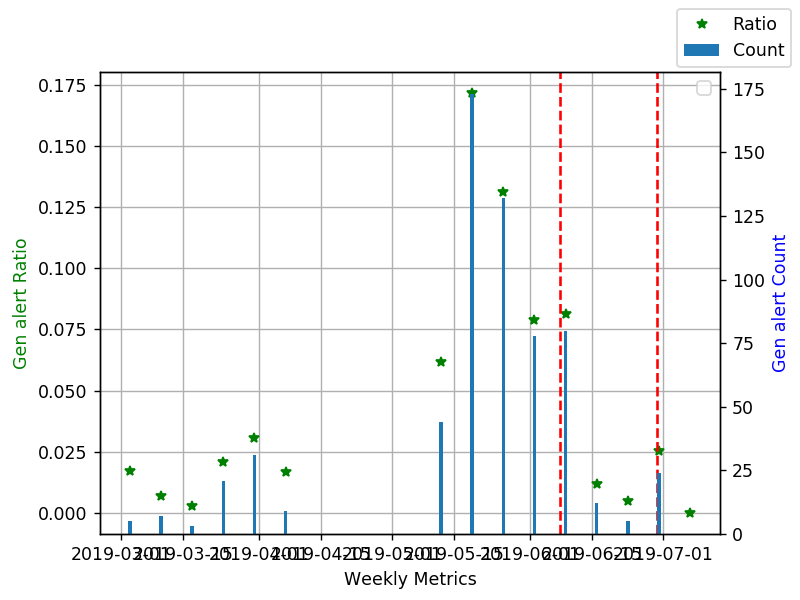

In [22]:
# Create  alert plot

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(resultsdf['gen_alert_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index,resultsdf['gen_alert_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Gen alert Ratio', color = 'g')
ax2.set_ylabel('Gen alert Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')

plt.show()

In [23]:
resultsdf

,anomaly_count,online_status_count,flips_count,gen_alert_count,TotalCounts,anomaly_ratio,flips_ratio,gen_alert_ratio
timestamp,,,,,,,,
2019-03-03,6,288,5,5,288,0.020833,0.017361,0.017361
2019-03-10,171,988,8,7,1008,0.173077,0.008097,0.007085
2019-03-17,3,1008,3,3,1008,0.002976,0.002976,0.002976
2019-03-24,163,1008,21,21,1008,0.161706,0.020833,0.020833
2019-03-31,197,1008,31,31,1008,0.195437,0.030754,0.030754
2019-04-07,246,533,9,9,1008,0.461538,0.016886,0.016886
2019-04-14,548,0,8,0,1008,inf,inf,NaN
2019-04-21,322,0,12,0,1008,inf,inf,NaN
2019-04-28,17,0,1,0,1008,inf,inf,NaN


In [56]:
#resultsdf.to_csv('ResultsdfGT4.csv')

In [19]:
#df[['anomaly','alert','gen_alert']].resample('M').sum()